In [1]:
import bento
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from hmr import Reloader
from scipy.stats import pearsonr, spearmanr

bento = Reloader(bento)

# Load seqFISH+ dataset

In [2]:
adata = bento.datasets.load_dataset("seqfish")

In [4]:
bento.tl.lp(adata)

In [5]:
bento.pp.set_points(adata)

In [6]:
gs = ["FXR1", "SF3A3", "CDC40", "NOL12", "STAU2"]

In [7]:
rbp_gene = pd.read_csv("../../data/seqfish_rbpxgene_05282022.csv", index_col=0)
rbp_bind = rbp_gene.loc[gs] > 0
adata.var = adata.var.join(rbp_bind.T).fillna(False)

In [8]:
clip = pd.read_csv("../../data/clip_peaks.csv", index_col=0)
stau2_3utr = clip[(clip["Rbp"] == "STAU2") & (clip["Region"] == "three_prime_utrs")]

In [9]:
targets = stau2_3utr["gene"].unique().tolist()

In [10]:
@bento.plotting._utils.savefig
def radviz_bound(
    data,
    all_genes,
    target_genes,
    kind="scatter",
    hue="Pattern",
    sizes=(2, 100),
    gridsize=20,
    random_state=4,
    fname=None,
    **kwargs,
):
    """
    Parameters
    ----------
    data : AnnData
        Spatial formatted AnnData
    kind : str
        'Scatter' for scatterplot, 'hex' for hex plot
    sizes : tuple
        Minimum and maximum point size range
    gridsize : int
        Number of bins along each axis
    **kwargs
        Options to pass to matplotlib plotting method.
    """
    # sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white','axes.grid' : False,'legend.frameon':True})
    palette = dict(zip(bento._utils.PATTERN_NAMES, bento._utils.PATTERN_COLORS))

    # RADVIZ plot
    figsize = (3, 3)
    fig = plt.figure(figsize=figsize)

    # Use Plot the "circular" axis and labels, hide points
    col_names = [f"{p}_fraction" for p in bento._utils.PATTERN_NAMES]
    gene_frac = data.var[col_names]
    gene_frac.columns = bento._utils.PATTERN_NAMES
    gene_frac["Pattern"] = gene_frac.idxmax(axis=1)
    binding_stat = []
    for idx, row in gene_frac.iterrows():
        if idx in target_genes:
            binding_stat.append("target_bound")
        elif idx in all_genes:
            binding_stat.append("generally_bound")
        else:
            binding_stat.append("not_bound")
    gene_frac_copy = gene_frac.copy()
    gene_frac_copy["Pattern"] = ""
    ax = pd.plotting.radviz(gene_frac_copy, "Pattern", s=0)
    del gene_frac_copy
    ax.get_legend().remove()
    circle = plt.Circle((0, 0), radius=1, color="black", fill=False)
    ax.add_patch(circle)

    # Hide 2D axes
    ax.axis(False)

    # Get points
    pts = []
    for c in ax.collections:
        pts.extend(c.get_offsets().data)

    pts = np.array(pts).reshape(-1, 2)
    xy = pd.DataFrame(pts, index=gene_frac.index)
    xy["Pattern"] = gene_frac["Pattern"]
    xy["Binding"] = binding_stat

    # Plot points as scatter or hex
    if kind == "scatter":

        del ax.collections[0]

        # Scale point size by max
        xy["Fraction of cells"] = gene_frac.iloc[:, :5].max(axis=1)
        # Plot all points
        # sns.scatterplot(
        #     data=xy[xy["Binding"] == "not_bound"],
        #     x=0,
        #     y=1,
        #     # gridsize=20,
        #     # extent=(-1, 1, -1, 1),
        #     fill=True,
        #     levels=100,
        #     cmap=sns.light_palette("grey", as_cmap=True),
        #     # mincnt=1,
        #     # colorbar=False,
        #     ax=ax,
        #     **kwargs,
        # )
        xy[xy["Binding"] == "not_bound"].plot.hexbin(
            x=0,
            y=1,
            gridsize=gridsize,
            extent=(-1, 1, -1, 1),
            cmap=sns.light_palette("lightseagreen", as_cmap=True),
            mincnt=1,
            colorbar=False,
            ax=ax,
            **kwargs,
        )
        sns.scatterplot(
            data=xy[xy["Binding"] == "generally_bound"],
            x=0,
            y=1,
            # hue=hue,
            s=30,
            linewidth=0,
            color="navy",
            alpha=0.7,
            ax=ax,
            **kwargs,
        )
        sns.scatterplot(
            data=xy[xy["Binding"] == "target_bound"],
            x=0,
            y=1,
            # hue=hue,
            s=30,
            linewidth=0,
            color="orange",
            alpha=1,
            ax=ax,
            **kwargs,
        )
        plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Saved to ../../figures/fig4d_stau2_3utr_targets.svg


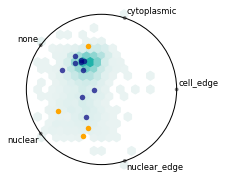

In [11]:
radviz_bound(
    adata,
    adata.var_names[adata.var["STAU2"]],
    targets,
    fname="../../figures/fig4d_stau2_3utr_targets.svg",
)

In [12]:
@bento.plotting._utils.savefig
def radviz_rbp(
    data,
    target_genes,
    kind="scatter",
    hue="Pattern",
    s=20,
    size=None,
    sizes=None,
    gridsize=20,
    random_state=4,
    legend=True,
    fname=None,
    **kwargs,
):
    """
    Parameters
    ----------
    data : AnnData
        Spatial formatted AnnData
    kind : str
        'Scatter' for scatterplot, 'hex' for hex plot
    sizes : tuple
        Minimum and maximum point size range
    gridsize : int
        Number of bins along each axis
    **kwargs
        Options to pass to matplotlib plotting method.
    """
    # sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white','axes.grid' : False,'legend.frameon':True})
    # sns.set(font_scale=2)
    palette = dict(zip(bento._utils.PATTERN_NAMES, bento._utils.PATTERN_COLORS))

    # RADVIZ plot

    figsize = (3, 3)
    fig = plt.figure(figsize=figsize)

    # Use Plot the "circular" axis and labels, hide points
    col_names = [f"{p}_fraction" for p in bento._utils.PATTERN_NAMES]
    gene_frac = data.var[col_names]
    gene_frac.columns = bento._utils.PATTERN_NAMES
    gene_frac["Pattern"] = gene_frac.idxmax(axis=1)
    binding_stat = []
    for idx, row in gene_frac.iterrows():
        if idx in target_genes:
            binding_stat.append("target_bound")
        else:
            binding_stat.append("not_bound")
    gene_frac_copy = gene_frac.copy()
    gene_frac_copy["Pattern"] = ""
    ax = pd.plotting.radviz(gene_frac_copy, "Pattern", s=0)
    del gene_frac_copy
    ax.get_legend().remove()
    circle = plt.Circle((0, 0), radius=1, color="black", fill=False)
    ax.add_patch(circle)

    # Hide 2D axes
    ax.axis(False)

    # Get points
    pts = []
    for c in ax.collections:
        pts.extend(c.get_offsets().data)

    pts = np.array(pts).reshape(-1, 2)
    xy = pd.DataFrame(pts, index=gene_frac.index)
    xy["Pattern"] = gene_frac["Pattern"]
    xy["Binding"] = binding_stat

    # Plot points as scatter or hex
    if kind == "scatter":

        del ax.collections[0]

        # Scale point size by max
        xy["Fraction of cells"] = gene_frac.iloc[:, :5].max(axis=1)
        # Sort spots by category
        sort_list = ["cytoplasmic", "cell_edge", "nuclear_edge", "nuclear", "random"]
        # Plot all points
        xy[xy["Binding"] == "not_bound"].plot.hexbin(
            x=0,
            y=1,
            gridsize=gridsize,
            extent=(-1, 1, -1, 1),
            cmap=sns.light_palette("lightseagreen", as_cmap=True),
            mincnt=1,
            colorbar=False,
            ax=ax,
            **kwargs,
        )
        sns.scatterplot(
            data=xy[xy["Binding"] == "target_bound"],
            x=0,
            y=1,
            hue="Pattern",
            s=40,
            size=size,
            sizes=sizes,
            linewidth=0,
            palette=palette,
            alpha=0.7,
            ax=ax,
            **kwargs,
        )

        if legend:
            plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False)
        else:
            plt.legend().remove()

        # plt.colorbar(
        #     ax.collections[-1], cax=fig.add_axes([1, 0.4, 0.05, 0.3]), label="genes"
        # )

No handles with labels found to put in legend.


Saved to ../../figures/fig4b_FXR1.svg


No handles with labels found to put in legend.


Saved to ../../figures/fig4b_SF3A3.svg


No handles with labels found to put in legend.


Saved to ../../figures/fig4b_CDC40.svg


No handles with labels found to put in legend.


Saved to ../../figures/fig4b_NOL12.svg


No handles with labels found to put in legend.


Saved to ../../figures/fig4b_STAU2.svg


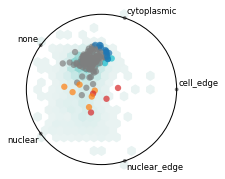

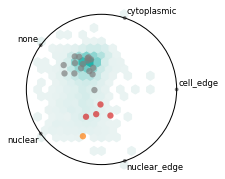

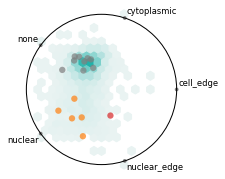

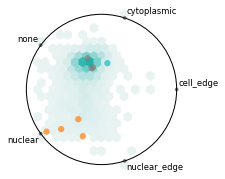

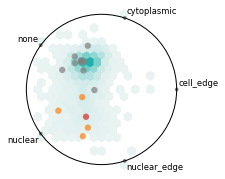

In [13]:
for rbp in gs:
    radviz_rbp(
        adata,
        adata.var_names[adata.var[rbp]],
        hue=None,
        s=10,
        sizes=None,
        legend=False,
        fname=f"../../figures/fig4b_{rbp}.svg",
    )
    # break